In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from lib import RadioUNet_modules, RadioUNet_loaders

## Dataset Loader

In [3]:
maps_inds=np.arange(0,493,1,dtype=np.int16)
#Determenistic "random" shuffle of the maps:
np.random.seed(42)
np.random.shuffle(maps_inds)

trans = transforms.ToTensor()


Radio_train = RadioUNet_loaders.RadioUNet_dataset_s(maps_inds,0,250,csv_file='dataset100/database.csv',
                                    root_dir_buildings_miss='dataset100/png/buildings/',
                                    root_dir_buildings_all='dataset100/png/buildingsN/',
                                    root_dir_antenna='dataset100/png/antenna/',
                                    root_dir_gain='dataset100/png/gain/',transform = trans,miss=1, fix_samples=0)
Radio_val = RadioUNet_loaders.RadioUNet_dataset_s(maps_inds,251,390,csv_file='dataset100/database.csv',
                                    root_dir_buildings_miss='dataset100/png/buildings/',
                                    root_dir_buildings_all='dataset100/png/buildingsN/',
                                    root_dir_antenna='dataset100/png/antenna/',
                                    root_dir_gain='dataset100/png/gain/',transform = trans,miss=1, fix_samples=0)
Radio_test = RadioUNet_loaders.RadioUNet_dataset_s(maps_inds,391,494,csv_file='dataset100/database.csv',
                                    root_dir_buildings_miss='dataset100/png/buildings/',
                                    root_dir_buildings_all='dataset100/png/buildingsN/',
                                    root_dir_antenna='dataset100/png/antenna/',
                                    root_dir_gain='dataset100/png/gain/',transform = trans,miss=1, fix_samples=0)

image_datasets = {
    'train': Radio_train, 'val': Radio_val
}


batch_size = 15


dataloaders = {
    'train': DataLoader(Radio_train, batch_size=batch_size, shuffle=True, num_workers=10),
    'val': DataLoader(Radio_val, batch_size=batch_size, shuffle=True, num_workers=10)
}

## Test Sample Image

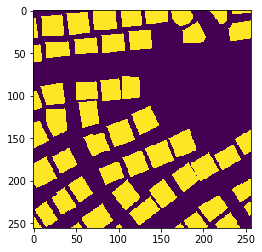

In [4]:
i=146
image_build_ant, image_gain = Radio_val[i]
plt.imshow(image_build_ant[0][:][:])

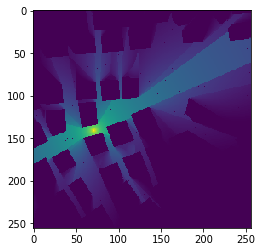

In [5]:
plt.imshow(-image_build_ant[2]+image_gain[0])

## Model Summary

In [7]:
from torchsummary import summary

torch.set_default_dtype(torch.float32)
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.backends.cudnn.enabled
model =RadioUNet_modules.RadioUNet_module_s()
model.cuda()
summary(model, input_size=(3, 256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 256, 256]             168
              ReLU-2          [-1, 6, 256, 256]               0
         MaxPool2d-3          [-1, 6, 256, 256]               0
            Conv2d-4         [-1, 40, 256, 256]           6,040
              ReLU-5         [-1, 40, 256, 256]               0
         MaxPool2d-6         [-1, 40, 128, 128]               0
            Conv2d-7         [-1, 60, 128, 128]          60,060
              ReLU-8         [-1, 60, 128, 128]               0
         MaxPool2d-9           [-1, 60, 64, 64]               0
           Conv2d-10           [-1, 80, 64, 64]         120,080
             ReLU-11           [-1, 80, 64, 64]               0
        MaxPool2d-12           [-1, 80, 64, 64]               0
           Conv2d-13          [-1, 100, 64, 64]         200,100
             ReLU-14          [-1, 100,

## Training Loop

In [8]:
#Adapted from https://github.com/usuyama/pytorch-unet

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn

def calc_loss(pred, target, metrics):
    criterion = nn.MSELoss()
    loss = criterion(pred, target)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=20):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("learning rate", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, targets, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=12)

cuda:0
Epoch 0/11
----------
learning rate 0.0001
train: loss: 0.007831
val: loss: 0.003133
saving best model
18m 6s
Epoch 1/11
----------
learning rate 0.0001
train: loss: 0.002524
val: loss: 0.002035
saving best model
10m 42s
Epoch 2/11
----------
learning rate 0.0001
train: loss: 0.001965
val: loss: 0.001847
saving best model
8m 43s
Epoch 3/11
----------
learning rate 0.0001


## Test Example

In [ ]:
test_loader = DataLoader(Radio_test, batch_size=1, shuffle=True, num_workers=0)
inputs, target = next(iter(test_loader))
inputs = inputs.to(device)
target = target.to(device)
pred = model(inputs)
pred = (pred.detach().cpu().numpy() * 255).astype(np.uint8)
inputs = (inputs.detach().cpu().numpy() * 255).astype(np.uint8)

### Prediction plus samples:

In [ ]:
plt.imshow(pred[0][0]-2*inputs[0][2])

### Ground truth:

In [ ]:
Gtruth = (target.detach().cpu().numpy() * 255).astype(np.uint8)
print(Gtruth.shape)
plt.imshow(Gtruth[0][0])


## Save Model For Inference

In [ ]:
torch.save(model.state_dict(), 'Trained_Model_RadioUNet_s.pt')

## Load Model For Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RadioUNet_modules.RadioUNet_module_s()
model.load_state_dict(torch.load('Trained_Model_RadioUNet_s.pt'))
model.to(device)